# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':200000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "benchmark/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# Bias 
opes: OPES_METAD ARG=p.x,p.y TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data benchmark/


## Trajectory 

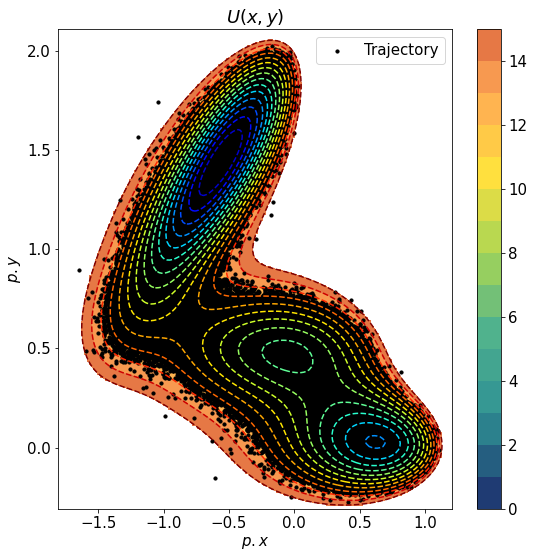

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values,load_dataframe(folder+"COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energy Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

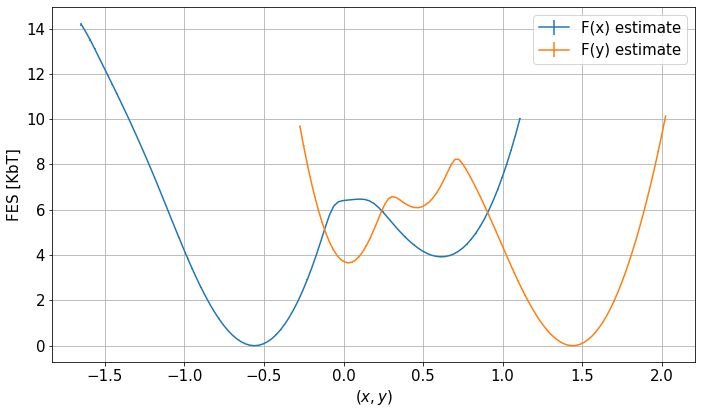

In [5]:
#-- estimation of Free Energy Surface 1D --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

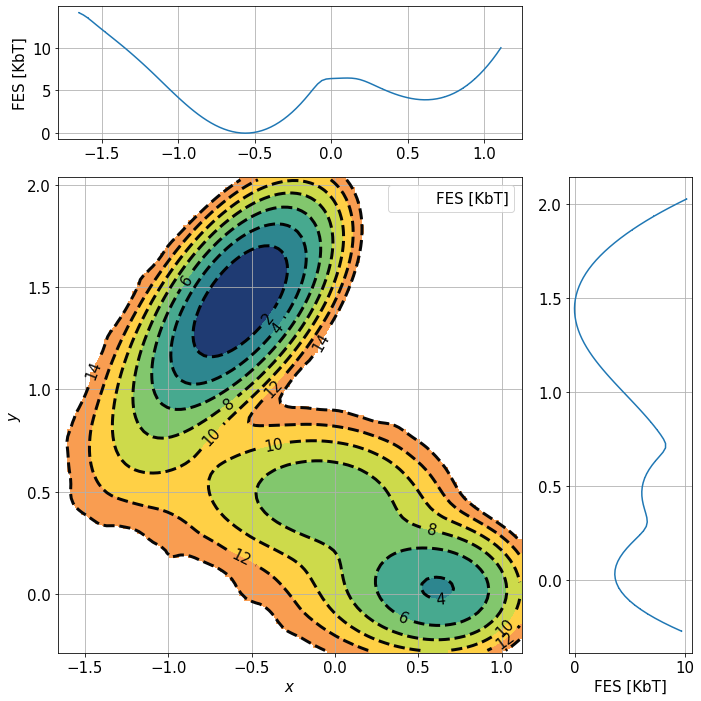

In [6]:
%%time
#-- time: 2h --# 

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 4)#, figure=fig)

ax_scatter = fig.add_subplot(gs[1:4,0:3])
ax_hist_x = fig.add_subplot(gs[0,:3])
ax_hist_y = fig.add_subplot(gs[1:,3])

#-- 2D plot --#
fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
bounds = np.arange(0, 16, 2.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]"
)
c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]",
)
#fig.colorbar(c, ax=ax_scatter,label="FES [KbT]")
c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]",
)
ax_scatter.legend(["FES [KbT]"])
c.clabel()
ax_scatter.grid()
ax_scatter.set_xlabel(r"$x$")
ax_scatter.set_ylabel(r"$y$")

#-- 1D plot --#
fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
ax_hist_x.errorbar(grid,fes,yerr=error)
ax_hist_x.set_ylabel("FES [KbT]")
ax_hist_x.grid()
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)
ax_hist_y.errorbar(fes,grid,xerr=error)
ax_hist_y.grid()
ax_hist_y.set_xlabel("FES [KbT]")

plt.tight_layout()
plt.show()

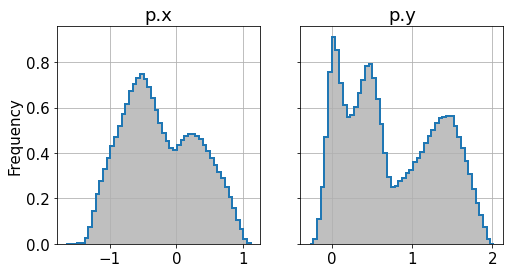

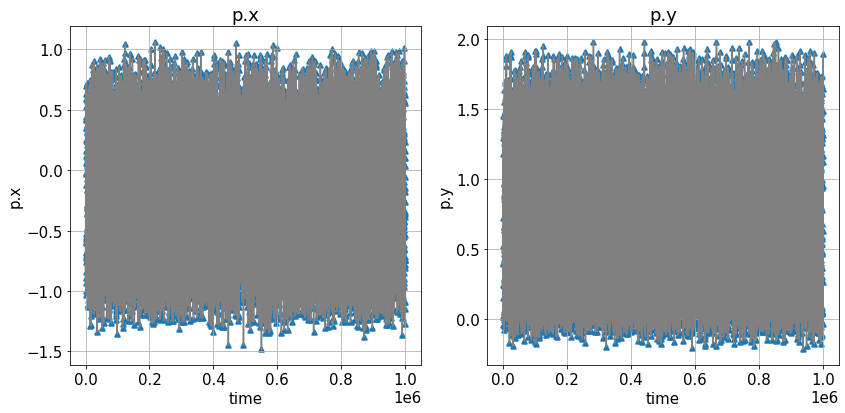

In [7]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::100].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::100].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [9]:
#-- each step is 1ps --#
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]

s = data[:]
weight = np.exp(logweight[:])
fes,grid,bounds,error = compute_fes(s, weights=weight,
                                    kbt=sim_parameters["temp"],
                                    blocks=2,
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=False)
ind1 = (grid<0) & (grid>-1.3)
ind2 = (grid>0) & (grid<1)
grid1 = grid[ ind1 ]
grid2 = grid[ ind2 ] 
I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)

res =(sim_parameters["temp"])*np.log(I1/I2)
print(res)

3.841414368598573


Text(0, 0.5, '$\\Delta F$ [kbT]')

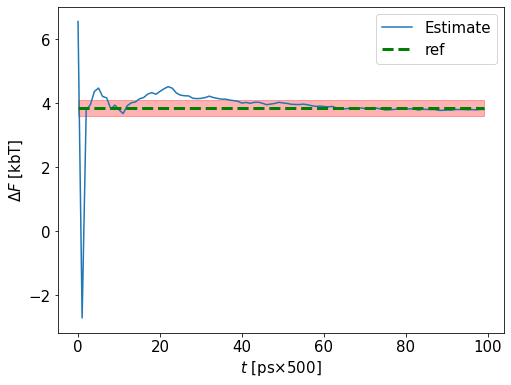

In [10]:
#-- each step is 1ps --#
#-- we are interested in the first 50 ns --#
last = 1*1000*50 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]
#-- each step is 1ps --#
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    
    deltaf = np.append(deltaf,(sim_parameters["temp"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.grid()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [kbT]")